In [1]:
from util._io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
import fastsca
import logging
import _rpstruct as rp
import _pnmf
from sklearn.decomposition import NMF
from sklearn import preprocessing
import random
from scipy.special import softmax
from sklearn.metrics.cluster import contingency_matrix,silhouette_score,adjusted_rand_score,calinski_harabasz_score,davies_bouldin_score
np.random.seed(42)

experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

sca = fastsca.FASTSCA()
sca.config = args
sca.initdata()
# sca.loaddata()
# print(sca.data.mtx.shape)
fn = sca.config.home + sca.config.experiment +sca.config.output + sca.config.sample_id+'/'+sca.config.sample_id



In [2]:
df_y = pd.read_csv(fn+'_rp_bulk.csv.gz')
df_y.shape


(115, 13745)

In [16]:
import _pnmf,_dcpnmfb,_dcpnmf,_dcpnmfv2
import importlib
importlib.reload(_dcpnmfb)
importlib.reload(_dcpnmf)
importlib.reload(_dcpnmfv2)

# m = _pnmf.PoissonMF(n_components=10,verbose=True)
# res = m.fit(df_y.to_numpy())

# m = _dcpnmf.DCPoissonMF(n_components=10)
# res = m.fit(df_y.to_numpy())

# m = _dcpnmfb.DCPoissonMFB(n_components=10)
# res = m.fit(df_y.to_numpy())

m = _dcpnmfv2.DCPoissonMF(n_components=10)
res = m.fit(df_y.to_numpy())


updaing null model....
	After ITERATION: 0	Objective: 26885334.98	Old objective: -inf	Improvement: nan
30062.192126223992
	After ITERATION: 1	Objective: 26885334.98	Old objective: 26885334.98	Improvement: 0.00000
30062.19212728197


(115, 10) (115, 10) (115, 10) (115, 10)
(10, 13745) (10, 13745) (10, 13745) (10, 13745)
	After ITERATION: 0	Objective: -28757098.16	Old objective: -inf	Improvement: nan
	After ITERATION: 1	Objective: -28760822.22	Old objective: -28757098.16	Improvement: -0.00013
	After ITERATION: 2	Objective: -28767222.68	Old objective: -28760822.22	Improvement: -0.00022
	After ITERATION: 3	Objective: -28775121.56	Old objective: -28767222.68	Improvement: -0.00027
	After ITERATION: 4	Objective: -28783492.83	Old objective: -28775121.56	Improvement: -0.00029
	After ITERATION: 5	Objective: -28791324.32	Old objective: -28783492.83	Improvement: -0.00027
	After ITERATION: 6	Objective: -28795526.31	Old objective: -28791324.32	Improvement: -0.00015
	After ITERATION: 7	Objective: -28

(10, 13745)


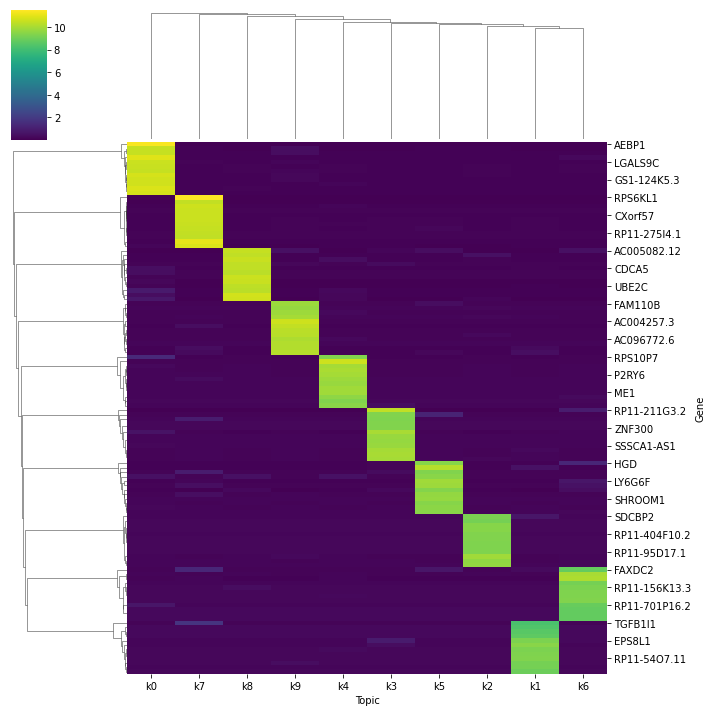

In [14]:
import _topics_util
import seaborn as sns

df_w = pd.DataFrame(res.Ebeta)
print(df_w.shape)
df_w.columns = sca.data.cols
df_top = _topics_util.get_topic_top_genes(df_w,top_n=12)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
# df_top[df_top>10]=10
sns.clustermap(df_top.T,cmap='viridis')